# <center> Railroad Segmentation (using SMP) </center>

In [0]:
!pip install -U segmentation-models-pytorch

In [0]:
import segmentation_models_pytorch as SMP
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os

#### Constants

In [0]:
GOOGLE_COLAB = True

DATA_DIR = 'segmentation/data/segmentation_data/'
if not GOOGLE_COLAB:
    DATA_DIR = os.path.realpath(DATA_DIR)

FEATURES = ['roads', 'railroads', 'wetlands']
POSITIVE = 'railroads'
NEGATIVE = [feature for feature in FEATURES if feature != POSITIVE]

N_SAMPLES = 400 # for each class
N_AUG_POS = 4
N_AUG_NEG = 0
N_POS = N_SAMPLES // N_AUG_POS
N_NEG = N_SAMPLES

BATCH_SIZE = 10

ROTATION_RANGE = 180
WINDOW_SIZE = 320

NUM_WORKERS = 2

N_EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
AUX_BRANCH = None

LOAD_MODEL = False
LOAD_MODEL_PATH = 'checkpoints/%s_best.pth'
CHECKPOINTS_DIR = 'checkpoints/'
SAVE_MODEL_PATH = os.path.join(CHECKPOINTS_DIR, '%s_best.pth')

MASK_THRESHOLD = 0.5

NORMALIZE = False

#### Settings for Google Collaboratory

In [4]:
if GOOGLE_COLAB:
    from google.colab import drive
    
    DATA_DIR = 'segmentation_data/'

    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive')

    assert os.path.exists(DATA_DIR), 'DATA_DIR does not exist in path'
    assert os.path.exists(CHECKPOINTS_DIR), 'CHECKPOINTS_DIR does not exist'
    
    import sys
    sys.path.append('/content/drive/My Drive')
    
    NUM_WORKERS = 10
    BATCH_SIZE = 20
    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from data_handler import get_data, sample_points
from transformer import SegmentationTransform
from utils import *

#### Starting with data

- Read dir to gather files
- Maps start with 'map_'
- Masks start with 'mask_'
- Rest have class type in their names
    - eg. railroads.txt

In [0]:
maps, masks, neg_files = get_filepaths(DATA_DIR, POSITIVE, NEGATIVE)

- Load maps and masks
- Caching them since maps are heavy (heavy IO)

In [7]:
LOADED_MAPS = load_images(maps)
LOADED_MASKS = load_images(masks, grayscale=True)
LOADED_MAPS[0].shape, LOADED_MASKS[0].shape

((13696, 11347, 3), (13696, 11347))

In [0]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
# plt.imshow(LOADED_MAPS[1])
# plt.subplot(1,2,2)
# plt.imshow(LOADED_MASKS[1], cmap='gray')
# plt.show()

- Sample N_POS pixels (white) from all the pixels that belong to the positive class and write to pos.txt
- Sample N_NEG pixels (black) for each of the negative class and write to neg{}.txt

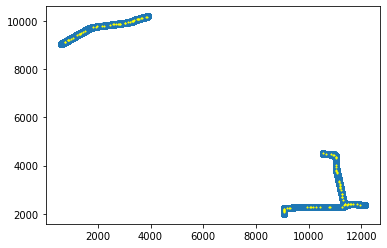

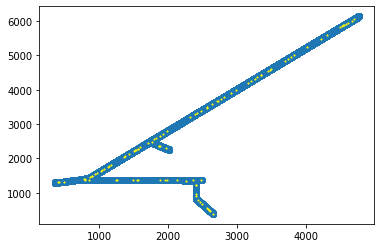

In [9]:
sample_points(maps, masks, neg_files, N_POS, N_NEG, representors=False, plot_pos=True)

#### Create Datasets and Data Loaders

In [0]:
class SegmentationDataset(Dataset):
	def __init__(self, data_points, transformer, win_size, scale=False):
		self.dataset = data_points
		self.transformer = transformer
		self.win_size = win_size
		self.scale = scale
		
	def preprocess(self, data_point):
		data_point = self.transformer(data_point)
		# mask channels == n_classes?
		
#         data_point['image'] = data_point['mask'].to(torch.float64)
#         data_point['mask'] = data_point['mask'].to(torch.long)
#         if self.scale: # totensor transform has done that for us
#             data_point['image'] /= 255.
#             data_point['mask'] /= 255
		return data_point
		
	def __len__(self):
		return len(self.dataset)
	
	def __getitem__(self, ix):
		assert ix < self.__len__(), 'Index must be within bounds (<len)'
		sample = self.preprocess(self.dataset[ix])
		return sample['images'], sample['masks']

In [11]:
# Default: val_size=0.1, shuffle=True, augment=True

train_data, val_data = get_data(maps, LOADED_MAPS, N_AUG_POS, N_AUG_NEG, WINDOW_SIZE, ROTATION_RANGE)
n_train, n_val = len(train_data), len(val_data)
n_train, n_val

(1620, 180)

In [0]:
if NORMALIZE:
    image_tf = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE, image_tf=image_tf)
else:
    transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE)

In [0]:
train_dataset = SegmentationDataset(train_data, transformer, WINDOW_SIZE)
val_dataset = SegmentationDataset(val_data, transformer, WINDOW_SIZE)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

#### Simple Tests

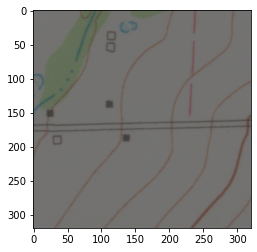

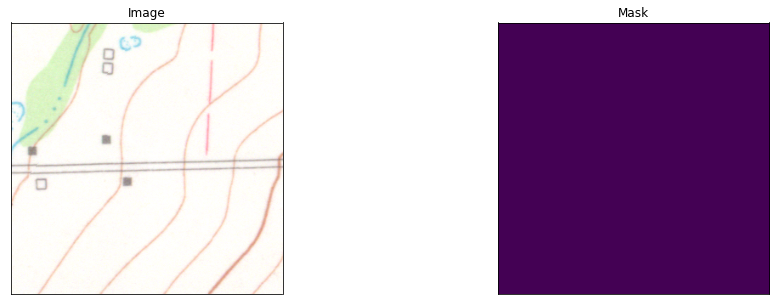

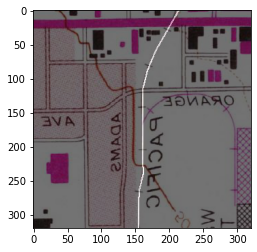

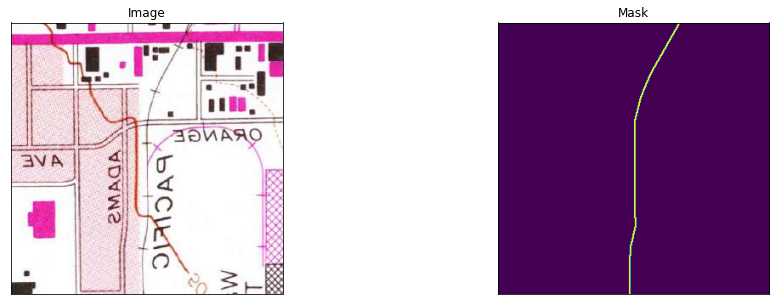

In [16]:
for i in np.random.choice(n_train, 2):
    image, mask = train_dataset[i]
    plot_overlay(image, mask)
    image = image.numpy().transpose((2,1,0))
    mask = mask.numpy().transpose((2,1,0)).squeeze()
    plot_segmentation_row(image=image, mask=mask)

### Load Model

In [0]:
MODEL_NAME = 'unet_resnet50'

model = SMP.Unet(encoder_name='resnet50', encoder_weights='imagenet', classes=1, activation='sigmoid')

In [0]:
LOAD_MODEL = False

if LOAD_MODEL:
#     model.load_state_dict(torch.load(LOAD_MODEL_PATH, map_location=DEVICE))
    model = torch.load(LOAD_MODEL_PATH % MODEL_NAME, map_location=DEVICE)
    
model = model.to(device=DEVICE)

### Training

In [0]:
metrics = [
    SMP.utils.metrics.IoU(threshold=0.5)
]
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
criterion = SMP.utils.losses.DiceLoss()

In [0]:
%load_ext tensorboard
%tensorboard --logdir runs

In [0]:
trainer = SMP.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

validator = SMP.utils.train.ValidEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

In [22]:
LOAD_MODEL_PATH % MODEL_NAME, SAVE_MODEL_PATH % MODEL_NAME

('checkpoints/unet_resnet50_best.pth', 'checkpoints/unet_resnet50_best.pth')

In [25]:
# best_score = 0
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")
    train_logs = trainer.run(train_loader)
    valid_logs = validator.run(val_loader)
    
    scheduler.step(valid_logs['dice_loss'])
    
    if valid_logs['iou_score'] > best_score:
        best_score = valid_logs['iou_score']
        torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)

Epoch 0   lr 0.0001
valid: 100%|██████████| 9/9 [00:31<00:00,  3.54s/it, dice_loss - 0.1997, iou_score - 0.7093]
Epoch 1   lr 0.0001
valid: 100%|██████████| 9/9 [00:33<00:00,  3.67s/it, dice_loss - 0.1921, iou_score - 0.7163]
Epoch 2   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.57s/it, dice_loss - 0.1817, iou_score - 0.7258]
Epoch 3   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.62s/it, dice_loss - 0.1714, iou_score - 0.7361]
Epoch 4   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.66s/it, dice_loss - 0.1751, iou_score - 0.729]
Epoch 5   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.65s/it, dice_loss - 0.1613, iou_score - 0.7452]
Epoch 6   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it, dice_loss - 0.1603, iou_score - 0.7461]
Epoch 7   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.64s/it, dice_loss - 0.1538, iou_score - 0.754]
Epoch 8   lr 0.0001
valid: 100%|██████████| 9/9 [00:32<00:00,  3.63s/it, dice_loss - 0.1527, iou_s

In [0]:
model = torch.load(LOAD_MODEL_PATH % MODEL_NAME , map_location=DEVICE)

In [0]:
image, mask = train_dataset[2]
pred = (model(image.unsqueeze(0)).squeeze(0) > MASK_THRESHOLD).to(torch.uint8)
image, pred, mask = image.detach().numpy().transpose((2,1,0)), pred.detach().numpy().transpose((2,1,0)), mask.detach().numpy().transpose((2,1,0))
plot_segmentation_row(image=image, pred=pred.squeeze(), mask=mask.squeeze())